### Task 1

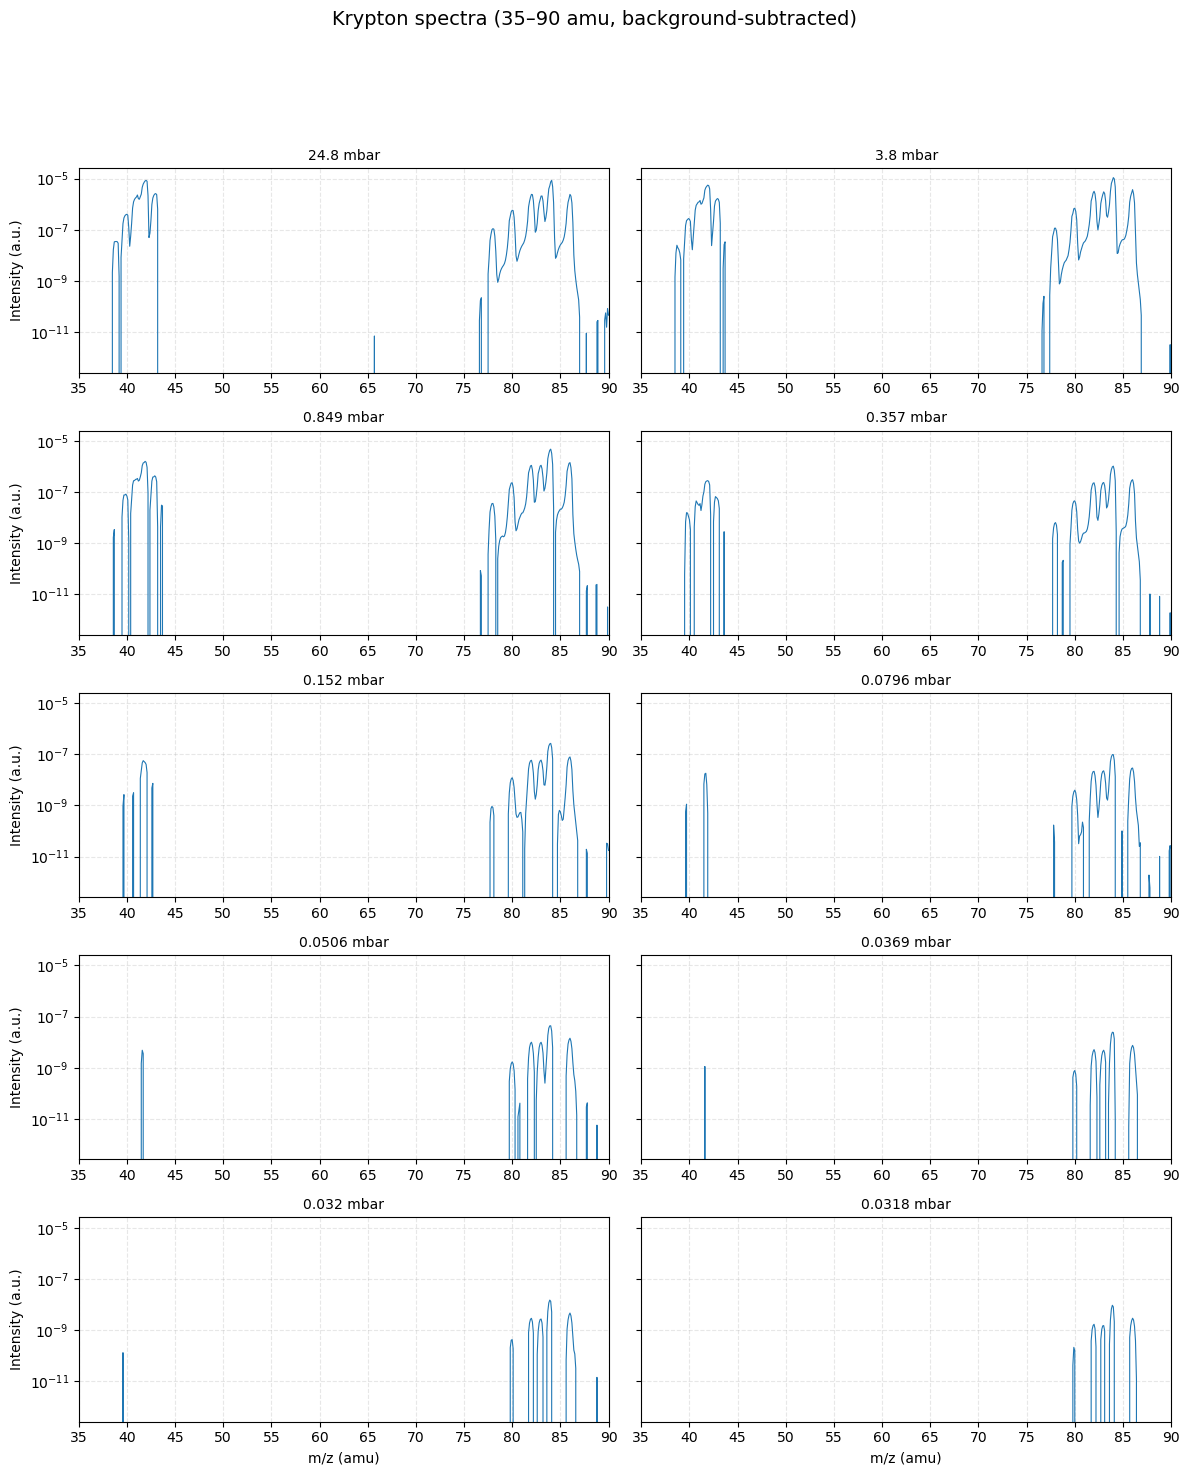

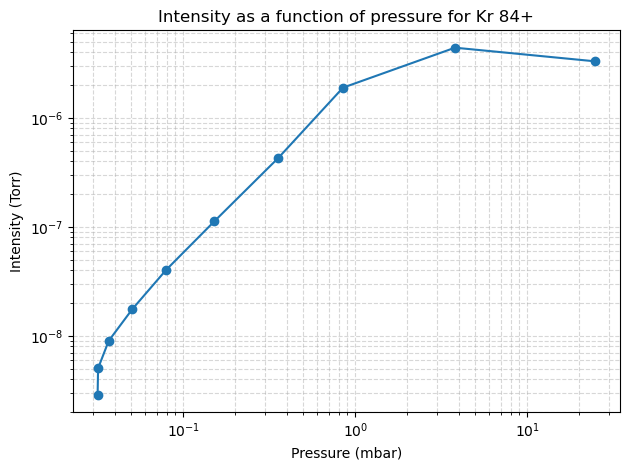


Isotopic composition from the 24.8 mbar scan (normalised to Kr‑84 = 100 %)

Isotope Natural (%) Single ion (%)            ± Double ion (%)           ± 
  ⁸78Kr       0.355           1.49  6771.321900           0.43  3191.012016
  ⁸80Kr       2.286           7.88 16045.343248           4.87 11003.888727
  ⁸82Kr      11.593          32.12 35844.996802          72.47 54431.565390
  ⁸83Kr      11.500          28.01 32943.747238          72.47 54431.565390
  ⁸84Kr      56.987         100.00 77809.740214         100.00 68854.065494
  ⁸86Kr      17.279          28.14 33041.218374          29.56 30129.843371


In [17]:
import re, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# ───── SETTINGS ─────────────────────────────────────────────────────────────
FILES = {
    24.8:  "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R1.txt",
     3.8:  "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R2.txt",
     0.849:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R3.txt",
     0.357:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R4.txt",
     0.152:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R5.txt",
    0.0796:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R6.txt",
    0.0506:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R7.txt",
    0.0369:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R8.txt",
    0.0320:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R9.txt",
    0.0318:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R10.txt",
}
BG_URL  = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/t1_vackground.txt"
REF_PRESSURE = 24.8

NATURAL = {78:0.355, 80:2.286, 82:11.593, 83:11.500, 84:56.987, 86:17.279}
KR1 = {m:(m-0.4, m+0.4) for m in NATURAL}
KR2 = {m//2:(m/2-0.4, m/2+0.4) for m in NATURAL}

# ───── HELPERS ──────────────────────────────────────────────────────────────
def read_spectrum(url:str)->pd.DataFrame:
    txt   = requests.get(url, timeout=20).text.splitlines()
    first = next(i for i,l in enumerate(txt) if l.lstrip() and l.lstrip()[0].isdigit())
    cleaned = [re.sub(r"\s*,\s*$","",l) for l in txt[first:] if l.strip()]
    df = pd.read_csv(StringIO("\n".join(cleaned)), header=None, names=["mass","I"],
                     engine="python", delimiter=",", skipinitialspace=True)
    df["mass"] = pd.to_numeric(df["mass"], errors="coerce")
    df = df.dropna(subset=["mass"])
    df["σI"] = np.sqrt(np.abs(df["I"]))
    return df

def integrate_peak(df, win):
    lo,hi = win
    m = (df["mass"]>=lo)&(df["mass"]<=hi)
    area   = np.trapz(df.loc[m,"I_bs"],  df.loc[m,"mass"])
    sigma2 = np.trapz(df.loc[m,"σI"]**2, df.loc[m,"mass"])
    return area, np.sqrt(sigma2)

def ratio(val,ref):
    n,sn=val; d,sd=ref
    r=n/d; sr=r*np.hypot(sn/n,sd/d)
    return r,sr

# ───── BACKGROUND ───────────────────────────────────────────────────────────
bg   = read_spectrum(BG_URL)
GRID = bg["mass"].values
BG_I = bg["I"].values

# ───── LOAD ALL FILES & PLOT ────────────────────────────────────────────────
LOW, HIGH = 35, 90   # ← display window
spectra=[]
fig,axs = plt.subplots(5,2,figsize=(12,15),sharey=True)
for (P,url),ax in zip(FILES.items(), axs.ravel()):
    df = (read_spectrum(url)
          .set_index("mass").reindex(GRID, method="nearest").reset_index())
    df["I_bs"] = (df["I"]-BG_I).clip(lower=0)
    df["σI"]   = np.sqrt(df["I_bs"])
    spectra.append(df.assign(P=P))

    w = df[(df["mass"]>=LOW)&(df["mass"]<=HIGH)]
    ax.plot(w["mass"], w["I_bs"], lw=.8)
    ax.set_xlim(LOW, HIGH)
    ax.set_xticks(np.arange(LOW, HIGH+1, 5))
    ax.set_yscale("log")
    ax.set_title(f"{P:g} mbar", fontsize=10)
    ax.grid(True, ls="--", alpha=.3)

for a in axs[:,0]: a.set_ylabel("Intensity (a.u.)")
for a in axs[-1,:]: a.set_xlabel("m/z (amu)")

fig.suptitle("Krypton spectra (35–90 amu, background‑subtracted)", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.92])
plt.show()

# ───── SINGLE-SCAN ANALYSIS ────────────────────────────────────────────────
df_ref = next(s for s in spectra if np.isclose(s["P"].iloc[0], REF_PRESSURE))
peaks1 = {m:integrate_peak(df_ref,w) for m,w in KR1.items()}
peaks2 = {m2:integrate_peak(df_ref,w) for m2,w in KR2.items()}

ref1 = peaks1[84]; ref2 = peaks2[42]
ratios1 = {m:ratio(peaks1[m],ref1)   for m in NATURAL}
ratios2 = {m:ratio(peaks2[m//2],ref2) for m in NATURAL}

curve = [(s["P"].iloc[0], integrate_peak(s, KR1[84])[0]) for s in spectra]
curve = pd.DataFrame(curve, columns=["P","I84"]).sort_values("P", ascending=False)

plt.errorbar(curve["P"], curve["I84"], fmt="o-")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Pressure (mbar)"); plt.ylabel("Intensity (Torr)")
plt.title("Intensity as a function of pressure for Kr 84+")
plt.grid(True, which="both", ls="--", alpha=.5)
plt.tight_layout(); plt.show()

rows=[{
    "Isotope":f"⁸{m}Kr",
    "Natural (%)":NATURAL[m],
    "Single ion (%)":100*ratios1[m][0],
    "±":100*ratios1[m][1],
    "Double ion (%)":100*ratios2[m][0],
    "± ":100*ratios2[m][1],
} for m in NATURAL]

print(f"\nIsotopic composition from the {REF_PRESSURE} mbar scan "
      "(normalised to Kr‑84 = 100 %)\n")
print(pd.DataFrame(rows).to_string(index=False,
      formatters={"Natural (%)":"{:.3f}".format,
                  "Single ion (%)":"{:.2f}".format,
                  "Double ion (%)":"{:.2f}".format}))


In [15]:

import numpy as np, pandas as pd, re, requests, io

# ---- helper --------------------------------------------------------
def read_spectrum(url: str) -> pd.DataFrame:
    raw = requests.get(url, timeout=20).text.splitlines()
    first = next(i for i,l in enumerate(raw) if l.lstrip() and l.lstrip()[0].isdigit())
    cleaned = [re.sub(r"\s*,\s*$", "", l) for l in raw[first:] if l.strip()]
    df = pd.read_csv(io.StringIO("\n".join(cleaned)), header=None,
                     names=["mass", "I"], engine="python",
                     delimiter=",", skipinitialspace=True)
    df["mass"] = pd.to_numeric(df["mass"], errors="coerce")
    df = df.dropna(subset=["mass"])
    return df

def integrate(df, lo, hi):
    m = (df["mass"]>=lo) & (df["mass"]<=hi)
    return np.trapz(df.loc[m,"I_bs"], df.loc[m,"mass"])

# ---- URLs ----------------------------------------------------------
spec_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R2.txt"        # 3.8 mbar
bg_url   = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/t1_vackground.txt"

# ---- load & background-subtract ------------------------------------
spec = read_spectrum(spec_url)
bg   = read_spectrum(bg_url).set_index("mass").reindex(spec["mass"],
                                                       method="nearest").reset_index()
spec["I_bs"] = (spec["I"] - bg["I"]).clip(lower=0)

# ---- Kr peak definitions ------------------------------------------
NATURAL = {78:0.355, 80:2.286, 82:11.593, 83:11.500, 84:56.987, 86:17.279}
kr_plus   = {m:(m-0.4, m+0.4) for m in NATURAL}           # Kr⁺ windows
kr_double = {m//2:(m/2-0.4, m/2+0.4) for m in NATURAL}    # Kr²⁺ windows

# ---- integrate peaks ----------------------------------------------
int_plus   = {m: integrate(spec, *w) for m, w in kr_plus.items()}
int_double = {m2: integrate(spec, *w) for m2, w in kr_double.items()}

tot_plus   = sum(int_plus.values())
tot_double = sum(int_double.values())

# ---- build DataFrames ---------------------------------------------
tbl_plus = (pd.DataFrame({
               "Mass (amu)"       : int_plus.keys(),
               "Intensity (Torr)" : int_plus.values(),
               "Exp %"            : [v/tot_plus*100  for v in int_plus.values()],
               "Natural %"        : [NATURAL[m] for m in int_plus.keys()],
           })
           .sort_values("Mass (amu)"))

tbl_double = (pd.DataFrame({
                  "Mass (amu)"       : int_double.keys(),   # 39–43 amu
                  "Intensity (Torr)" : int_double.values(),
                  "Exp %"            : [v/tot_double*100 for v in int_double.values()],
                  "Natural %"        : [NATURAL[m*2] for m in int_double.keys()],
              })
              .sort_values("Mass (amu)"))

# ---- display -------------------------------------------------------
print("\nKrypton 3.8 mbar  —  single-charged isotopes\n")
print(tbl_plus.to_string(index=False, formatters={
        "Intensity (Torr)": "{:.3e}".format,
        "Exp %":            "{:.2f}".format,
        "Natural %":        "{:.3f}".format}))

print("\nKrypton 3.8 mbar  —  double-charged isotopes\n")
print(tbl_double.to_string(index=False, formatters={
        "Intensity (Torr)": "{:.3e}".format,
        "Exp %":            "{:.2f}".format,
        "Natural %":        "{:.3f}".format}))



Krypton 3.8 mbar  —  single-charged isotopes

 Mass (amu) Intensity (Torr) Exp % Natural %
         78        5.010e-08  0.58     0.355
         80        2.967e-07  3.41     2.286
         82        1.318e-06 15.14    11.593
         83        1.268e-06 14.58    11.500
         84        4.407e-06 50.64    56.987
         86        1.362e-06 15.65    17.279

Krypton 3.8 mbar  —  double-charged isotopes

 Mass (amu) Intensity (Torr) Exp % Natural %
         39        8.989e-09  0.16     0.355
         40        1.375e-07  2.39     2.286
         41        2.158e-06 37.55    11.593
         42        2.662e-06 46.32    56.987
         43        7.804e-07 13.58    17.279


### Task 2

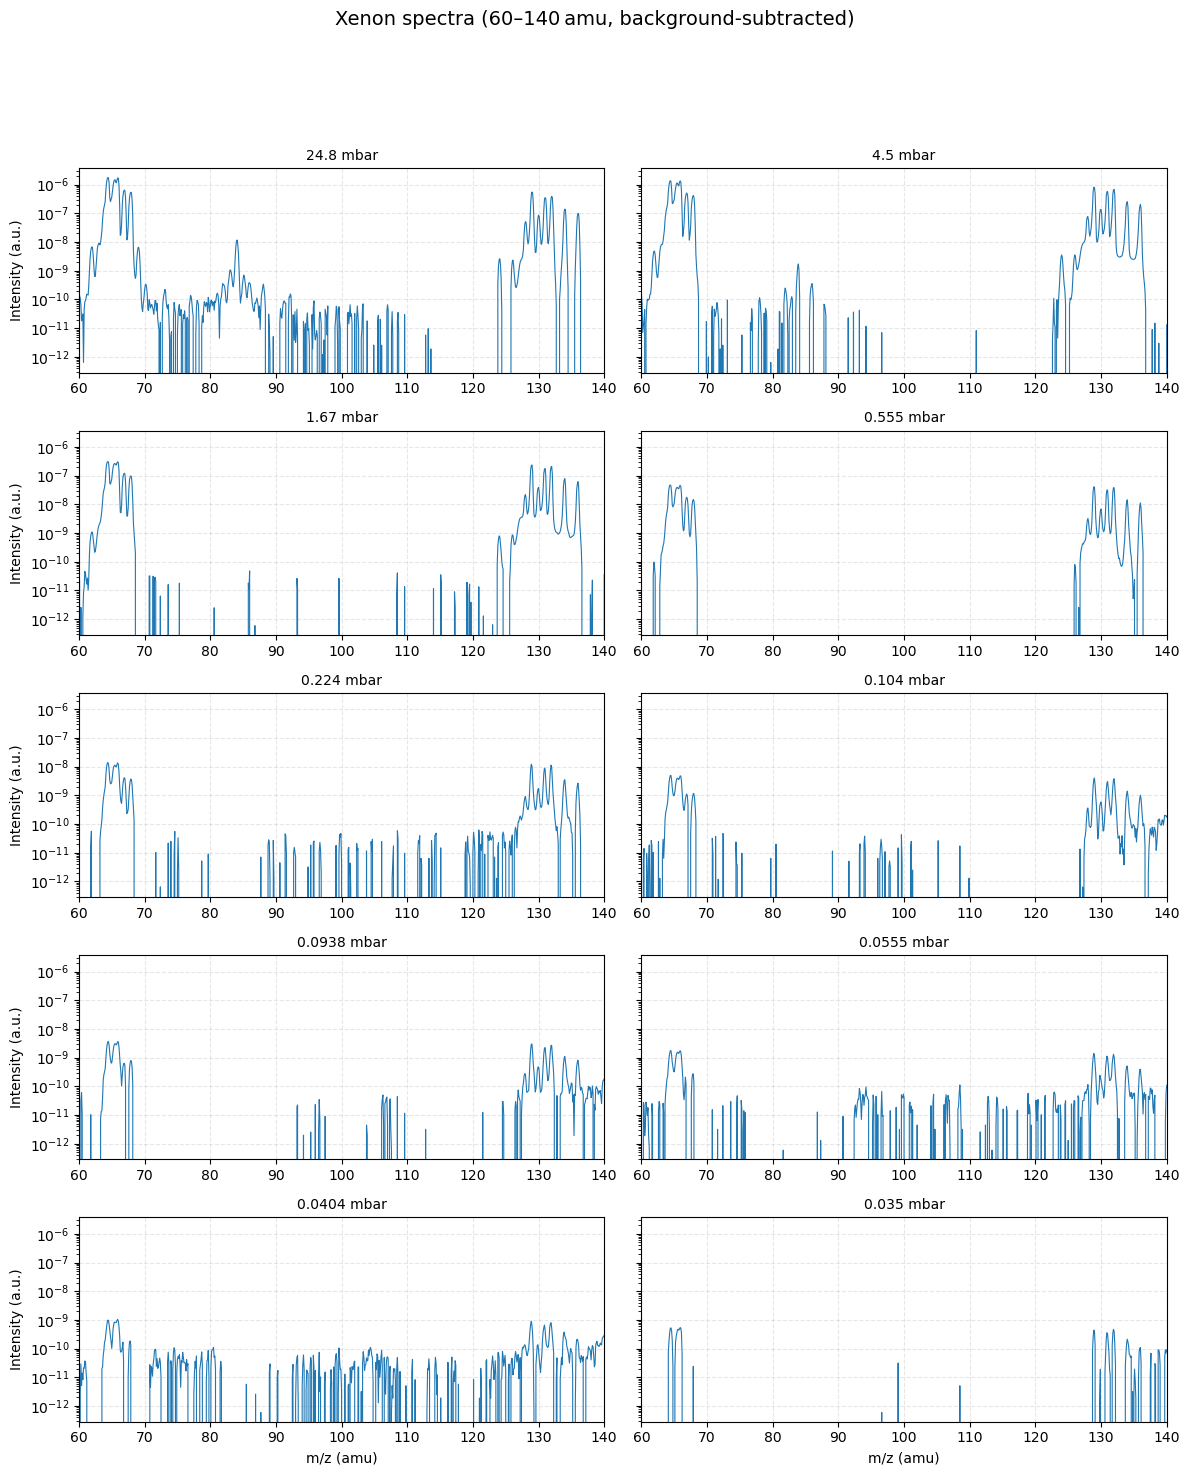

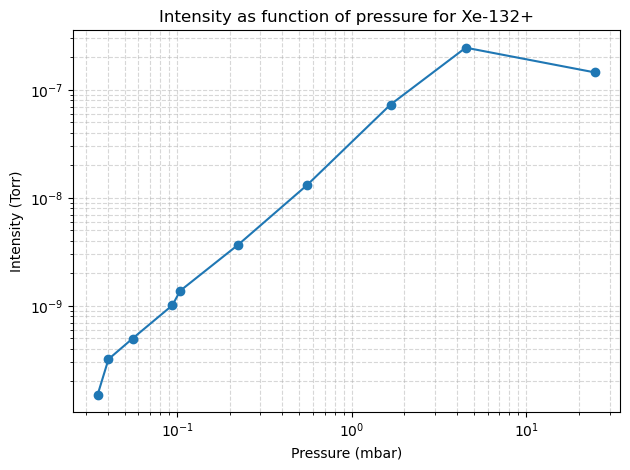


Isotopic composition from the 24.8 mbar Xe scan (normalised to Xe‑132 = 100 %)

Isotope Natural (%) Single ion (%)             ± Double ion (%)            ± 
  124Xe       0.095           0.64  21060.481240           0.40   7112.071926
  126Xe       0.089           0.58  20153.649350           0.76   9885.532597
  128Xe       1.910          14.50 107123.246170         106.19 166918.354072
  129Xe      26.401         141.38 485711.539180         106.19 166918.354072
  130Xe       4.071          23.07 140077.765194         127.64 192282.964916
  131Xe      21.232          93.12 352578.957944         127.64 192282.964916
  132Xe      26.909         100.00 371826.107614         100.00 159531.177644
  134Xe      10.436          34.91 180446.772681          35.46  78184.239467
  136Xe       8.857          24.91 146658.842425          29.55  69799.510226


In [18]:


import re, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# ───── SETTINGS ────────────────────────────────────────────────────────────
FILES = {
    24.8 : "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R1.txt",
     4.5 : "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R2.txt",
     1.67: "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R3.txt",
     0.555:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R4.txt",
     0.224:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R5.txt",
     0.104:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R6.txt",
    0.0938:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R7.txt",
     0.0555:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R8.txt",
     0.0404:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R9.txt",
     0.0350:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R10.txt",
}
BG_URL = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/Background.txt"
REF_PRESSURE = 24.8   # scan used for quantitative analysis

# natural abundances (NIST)
NATURAL = {124:0.0952, 126:0.0890, 128:1.9102, 129:26.4006,
           130:4.0710, 131:21.2324, 132:26.9086, 134:10.4357, 136:8.8573}

# peak windows ±0.4 amu
XE1 = {m:(m-0.4, m+0.4) for m in NATURAL}           # Xe⁺
XE2 = {m//2:(m/2-0.4, m/2+0.4) for m in NATURAL}    # Xe²⁺ (62–68 amu)

# ───── HELPERS ─────────────────────────────────────────────────────────────
def read_spectrum(url: str) -> pd.DataFrame:
    """Download RGA text file, return DataFrame(mass, I, σI)."""
    raw = requests.get(url, timeout=20).text.splitlines()
    first = next(i for i, l in enumerate(raw) if l.lstrip() and l.lstrip()[0].isdigit())
    cleaned = [re.sub(r"\s*,\s*$", "", l) for l in raw[first:] if l.strip()]
    df = pd.read_csv(StringIO("\n".join(cleaned)), header=None, names=["mass", "I"],
                     engine="python", delimiter=",", skipinitialspace=True)
    df["mass"] = pd.to_numeric(df["mass"], errors="coerce")
    df = df.dropna(subset=["mass"])
    df["σI"] = np.sqrt(np.abs(df["I"]))
    return df

def integrate_peak(df: pd.DataFrame, window):
    lo, hi = window
    m = (df["mass"] >= lo) & (df["mass"] <= hi)
    area = np.trapz(df.loc[m, "I_bs"], df.loc[m, "mass"])
    sigma2 = np.trapz(df.loc[m, "σI"]**2, df.loc[m, "mass"])
    return area, np.sqrt(sigma2)

def ratio(val, ref):
    n, sn = val
    d, sd = ref
    r = n / d
    sr = r * np.hypot(sn / n, sd / d)
    return r, sr

# ───── BACKGROUND ──────────────────────────────────────────────────────────
bg = read_spectrum(BG_URL)
GRID = bg["mass"].values
BG_I = bg["I"].values

# ───── PLOT ALL 10 SCANS (60–140 amu) ──────────────────────────────────────
LOW, HIGH = 60, 140
spectra = []
fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharey=True)

for (P, url), ax in zip(FILES.items(), axs.ravel()):
    df = (read_spectrum(url)
          .set_index("mass").reindex(GRID, method="nearest").reset_index())
    df["I_bs"] = (df["I"] - BG_I).clip(lower=0)
    df["σI"] = np.sqrt(df["I_bs"])
    spectra.append(df.assign(P=P))

    w = df[(df["mass"] >= LOW) & (df["mass"] <= HIGH)]
    ax.plot(w["mass"], w["I_bs"], lw=.8)
    ax.set_xlim(LOW, HIGH)
    ax.set_xticks(np.arange(LOW, HIGH + 1, 10))
    ax.set_yscale("log")
    ax.set_title(f"{P:g} mbar", fontsize=10)
    ax.grid(True, ls="--", alpha=.3)

for a in axs[:, 0]:
    a.set_ylabel("Intensity (a.u.)")
for a in axs[-1, :]:
    a.set_xlabel("m/z (amu)")

fig.suptitle("Xenon spectra (60–140 amu, background‑subtracted)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# ───── SINGLE‑SCAN ANALYSIS ───────────────────────────────────────────────
df_ref = next(s for s in spectra if np.isclose(s["P"].iloc[0], REF_PRESSURE))
peaks1 = {m: integrate_peak(df_ref, w) for m, w in XE1.items()}
peaks2 = {m2: integrate_peak(df_ref, w) for m2, w in XE2.items()}

ref1 = peaks1[132]
ref2 = peaks2[66]
ratios1 = {m: ratio(peaks1[m], ref1) for m in NATURAL}
ratios2 = {m: ratio(peaks2[m // 2], ref2) for m in NATURAL}

curve = [(s["P"].iloc[0], integrate_peak(s, XE1[132])[0]) for s in spectra]
curve = pd.DataFrame(curve, columns=["P", "I132"]).sort_values("P", ascending=False)

plt.errorbar(curve["P"], curve["I132"], fmt="o-")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Pressure (mbar)"); plt.ylabel("Intensity (Torr)")
plt.title("Intensity as function of pressure for Xe-132+")
plt.grid(True, which="both", ls="--", alpha=.5)
plt.tight_layout(); plt.show()

rows = [{
    "Isotope": f"{m}Xe",
    "Natural (%)": NATURAL[m],
    "Single ion (%)": 100 * ratios1[m][0],
    "±": 100 * ratios1[m][1],
    "Double ion (%)": 100 * ratios2[m][0],
    "± ": 100 * ratios2[m][1],
} for m in NATURAL]

print(f"\nIsotopic composition from the {REF_PRESSURE} mbar Xe scan "
      "(normalised to Xe‑132 = 100 %)\n")
print(pd.DataFrame(rows).to_string(index=False,
      formatters={"Natural (%)": "{:.3f}".format,
                  "Single ion (%)": "{:.2f}".format,
                  "Double ion (%)": "{:.2f}".format}))


In [16]:
import numpy as np, pandas as pd, re, requests, io

# ---------- helper to read & clean -----------------------------------------
def read_spectrum(url: str) -> pd.DataFrame:
    raw = requests.get(url, timeout=20).text.splitlines()
    first = next(i for i,l in enumerate(raw) if l.lstrip() and l.lstrip()[0].isdigit())
    cleaned = [re.sub(r"\s*,\s*$", "", l) for l in raw[first:] if l.strip()]
    df = pd.read_csv(io.StringIO("\n".join(cleaned)), header=None,
                     names=["mass", "I"], engine="python",
                     delimiter=",", skipinitialspace=True)
    df["mass"] = pd.to_numeric(df["mass"], errors="coerce")
    df = df.dropna(subset=["mass"])
    return df

def integrate(df, lo, hi):
    m = (df["mass"]>=lo) & (df["mass"]<=hi)
    return np.trapz(df.loc[m,"I_bs"], df.loc[m,"mass"])

# ---------- URLs for 4.5 mbar scan & background -----------------------------
spec_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R2.txt"
bg_url   = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/Background.txt"

# ---------- load & subtract background --------------------------------------
spec = read_spectrum(spec_url)
bg   = read_spectrum(bg_url).set_index("mass").reindex(spec["mass"],
                                                       method="nearest").reset_index()
spec["I_bs"] = (spec["I"] - bg["I"]).clip(lower=0)

# ---------- Xe isotope data & peak windows ----------------------------------
NATURAL = {124:0.0952, 126:0.0890, 128:1.9102, 129:26.4006,
           130:4.0710, 131:21.2324, 132:26.9086, 134:10.4357, 136:8.8573}

xe_plus   = {m:(m-0.4, m+0.4) for m in NATURAL}            # Xe⁺
xe_double = {m//2:(m/2-0.4, m/2+0.4) for m in NATURAL}     # Xe²⁺

# ---------- integrate peak areas -------------------------------------------
int_plus   = {m: integrate(spec, *w) for m, w in xe_plus.items()}
int_double = {m2: integrate(spec, *w) for m2, w in xe_double.items()}

tot_plus   = sum(int_plus.values())
tot_double = sum(int_double.values())

# ---------- build tables ----------------------------------------------------
tbl_plus = (
    pd.DataFrame({
        "Mass (amu)"       : int_plus.keys(),
        "Intensity (Torr)" : int_plus.values(),
        "Exp %"            : [v/tot_plus*100  for v in int_plus.values()],
        "Natural %"        : [NATURAL[m] for m in int_plus.keys()],
    })
    .sort_values("Mass (amu)")
)

tbl_double = (
    pd.DataFrame({
        "Mass (amu)"       : int_double.keys(),   # 62–68 amu
        "Intensity (Torr)" : int_double.values(),
        "Exp %"            : [v/tot_double*100 for v in int_double.values()],
        "Natural %"        : [NATURAL[m*2] for m in int_double.keys()],
    })
    .sort_values("Mass (amu)")
)

# ---------- display ---------------------------------------------------------
print("\nXenon 4.5 mbar  —  single-charged isotopes\n")
print(tbl_plus.to_string(index=False, formatters={
        "Intensity (Torr)": "{:.3e}".format,
        "Exp %":            "{:.2f}".format,
        "Natural %":        "{:.3f}".format}))

print("\nXenon 4.5 mbar  —  double-charged isotopes\n")
print(tbl_double.to_string(index=False, formatters={
        "Intensity (Torr)": "{:.3e}".format,
        "Exp %":            "{:.2f}".format,
        "Natural %":        "{:.3f}".format}))



Xenon 4.5 mbar  —  single-charged isotopes

 Mass (amu) Intensity (Torr) Exp % Natural %
        124        1.368e-09  0.13     0.095
        126        1.511e-09  0.15     0.089
        128        3.369e-08  3.32     1.910
        129        2.991e-07 29.50    26.401
        130        5.615e-08  5.54     4.071
        131        2.158e-07 21.29    21.232
        132        2.453e-07 24.20    26.909
        134        9.045e-08  8.92    10.436
        136        7.040e-08  6.94     8.857

Xenon 4.5 mbar  —  double-charged isotopes

 Mass (amu) Intensity (Torr) Exp % Natural %
         62        2.233e-09  0.09     0.095
         63        5.772e-09  0.24     0.089
         64        6.388e-07 26.26     1.910
         65        7.972e-07 32.77     4.071
         66        5.942e-07 24.42    26.909
         67        2.172e-07  8.93    10.436
         68        1.773e-07  7.29     8.857


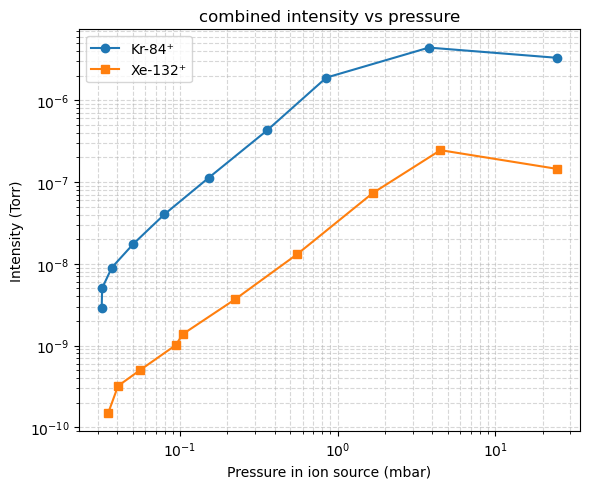

In [22]:
import numpy as np, pandas as pd, re, requests, io, matplotlib.pyplot as plt

def read_spectrum(url):
    raw = requests.get(url, timeout=20).text.splitlines()
    first = next(i for i,l in enumerate(raw) if l.lstrip() and l.lstrip()[0].isdigit())
    cleaned = [re.sub(r"\s*,\s*$", "", l) for l in raw[first:] if l.strip()]
    df = pd.read_csv(io.StringIO("\n".join(cleaned)), header=None,
                     names=["mass","I"], engine="python", delimiter=",",
                     skipinitialspace=True)
    df["mass"] = pd.to_numeric(df["mass"], errors="coerce")
    return df.dropna(subset=["mass"])

def integrate(df, lo, hi):
    m = (df["mass"]>=lo)&(df["mass"]<=hi)
    return np.trapz(df.loc[m,"I_bs"], df.loc[m,"mass"])

# ─── correct ASCII-digit URLs ─────────────────────────────────────────
KR_FILES = {
    24.8:  "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R1.txt",
     3.8:  "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R2.txt",
     0.849:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R3.txt",
     0.357:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R4.txt",
     0.152:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R5.txt",
    0.0796:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R6.txt",
    0.0506:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R7.txt",
    0.0369:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R8.txt",
    0.0320:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R9.txt",
    0.0318:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/R10.txt",
}
KR_BG = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%201/t1_vackground.txt"

XE_FILES = {
    24.8:  "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R1.txt",
     4.5:  "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R2.txt",
     1.67: "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R3.txt",
     0.555:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R4.txt",
     0.224:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R5.txt",
     0.104:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R6.txt",
    0.0938:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R7.txt",
     0.0555:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R8.txt",
     0.0404:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R9.txt",
     0.0350:"https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/R10.txt",
}
XE_BG = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%202/Background.txt"

# ─── load backgrounds once ──────────────────────────────────────────
kr_bg = read_spectrum(KR_BG)
xe_bg = read_spectrum(XE_BG)

# ─── build intensity vs P curves ────────────────────────────────────
kr_curve = []
for P, url in KR_FILES.items():
    sp = read_spectrum(url)
    bg = kr_bg.set_index("mass").reindex(sp["mass"], method="nearest").reset_index()
    sp["I_bs"] = (sp["I"] - bg["I"]).clip(lower=0)
    kr_curve.append((P, integrate(sp, 83.6, 84.4)))   # Kr-84 window

xe_curve = []
for P, url in XE_FILES.items():
    sp = read_spectrum(url)
    bg = xe_bg.set_index("mass").reindex(sp["mass"], method="nearest").reset_index()
    sp["I_bs"] = (sp["I"] - bg["I"]).clip(lower=0)
    xe_curve.append((P, integrate(sp, 131.6, 132.4))) # Xe-132 window

kr_df = pd.DataFrame(kr_curve, columns=["P","I"]).sort_values("P", ascending=False)
xe_df = pd.DataFrame(xe_curve, columns=["P","I"]).sort_values("P", ascending=False)

# ─── plot ───────────────────────────────────────────────────────────
plt.figure(figsize=(6,5))
plt.loglog(kr_df["P"], kr_df["I"], "o-", label="Kr-84⁺")
plt.loglog(xe_df["P"], xe_df["I"], "s-", label="Xe-132⁺")
plt.xlabel("Pressure in ion source (mbar)")
plt.ylabel("Intensity (Torr)")
plt.title("combined intensity vs pressure")
plt.grid(True, which="both", ls="--", alpha=.5)
plt.legend()
plt.tight_layout()
plt.show()


### Task 3.1

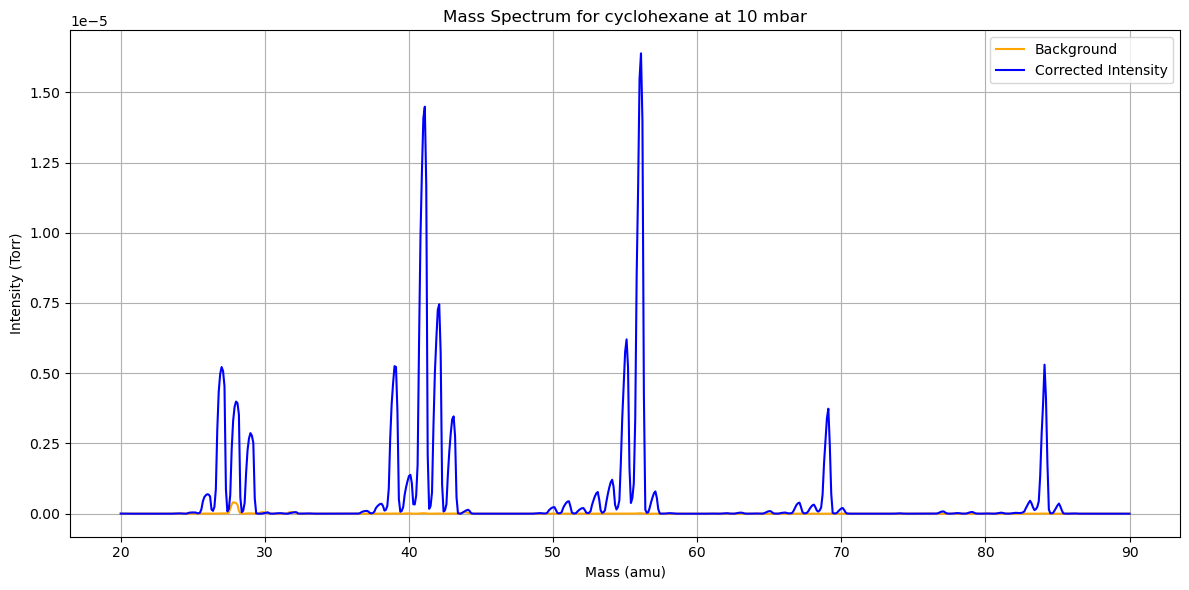

In [2]:
# @title Default title text
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO

# URLs to the raw data
data_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%203/R1.txt"
background_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%203/background.txt"

# Function to parse data from a GitHub raw URL
def parse_data_from_url(url):
    response = requests.get(url)
    lines = response.text.splitlines()

    # Find the start of the data block
    data_start_index = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('20.00') or line.strip().startswith(' 1.00'):
            data_start_index = i
            break

    # Parse the actual mass-intensity pairs
    masses = []
    intensities = []
    for line in lines[data_start_index:]:
        parts = line.strip().split(',')
        if len(parts) >= 2:
            try:
                mass = float(parts[0])
                intensity = float(parts[1])
                masses.append(mass)
                intensities.append(intensity)
            except ValueError:
                continue
    return pd.DataFrame({'mass': masses, 'intensity': intensities})

# Load and parse both datasets
data_df = parse_data_from_url(data_url)
background_df = parse_data_from_url(background_url)

# Merge on mass values
merged_df = pd.merge(data_df, background_df, on='mass', how='inner', suffixes=('_data', '_background'))

# Calculate corrected intensity, clip negatives to zero
merged_df['corrected_intensity'] = (merged_df['intensity_data'] - merged_df['intensity_background']).clip(lower=0)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(merged_df['mass'], merged_df['intensity_background'], color='orange', label='Background')
plt.plot(merged_df['mass'], merged_df['corrected_intensity'], color='blue', label='Corrected Intensity')
plt.xlabel('Mass (amu)')
plt.ylabel('Intensity (Torr)')
plt.title('Mass Spectrum for cyclohexane at 10 mbar')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Task 3.2

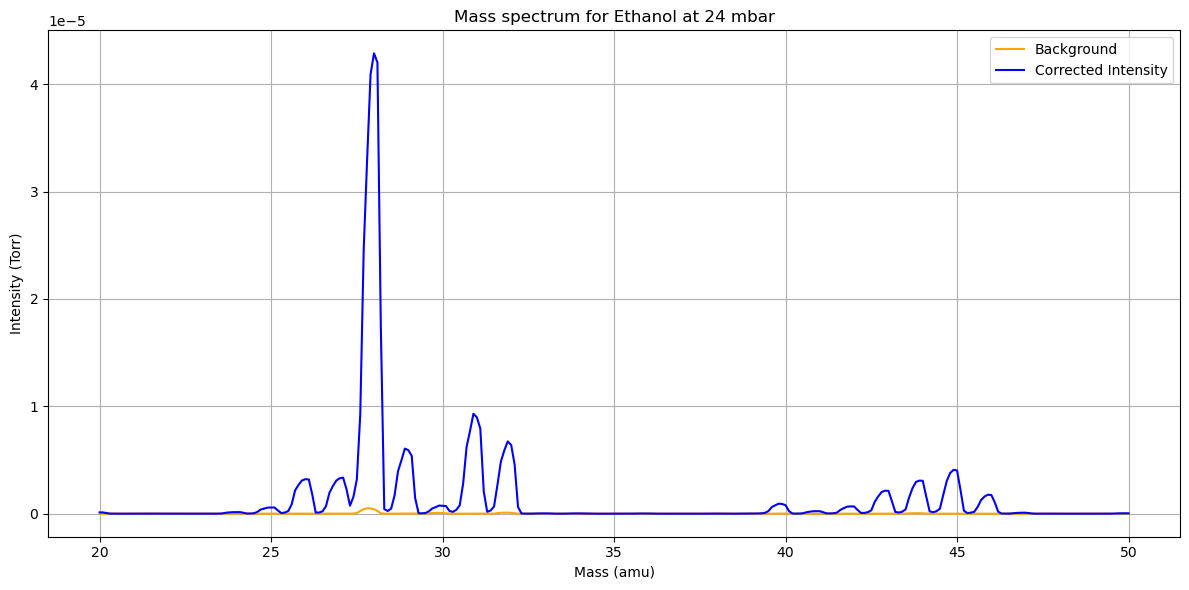

In [3]:
# @title Default title text
import pandas as pd
import matplotlib.pyplot as plt
import requests

# URLs for ethanol at 24 mbar
data_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/task%203.2/R1.txt"
background_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/task%203.2/background.txt"

# Function to parse data from GitHub
def parse_data_from_url(url):
    response = requests.get(url)
    lines = response.text.splitlines()

    data_start_index = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('20.00') or line.strip().startswith(' 1.00'):
            data_start_index = i
            break

    masses = []
    intensities = []
    for line in lines[data_start_index:]:
        parts = line.strip().split(',')
        if len(parts) >= 2:
            try:
                mass = float(parts[0])
                intensity = float(parts[1])
                masses.append(mass)
                intensities.append(intensity)
            except ValueError:
                continue
    return pd.DataFrame({'mass': masses, 'intensity': intensities})

# Load data
data_df = parse_data_from_url(data_url)
background_df = parse_data_from_url(background_url)

# Merge and correct
merged_df = pd.merge(data_df, background_df, on='mass', how='inner', suffixes=('_data', '_background'))
merged_df['corrected_intensity'] = (merged_df['intensity_data'] - merged_df['intensity_background']).clip(lower=0)

# Filter for 10–50 amu
filtered = merged_df[(merged_df['mass'] >= 10) & (merged_df['mass'] <= 50)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(filtered['mass'], filtered['intensity_background'], color='orange', label='Background')
plt.plot(filtered['mass'], filtered['corrected_intensity'], color='blue', label='Corrected Intensity')
plt.xlabel('Mass (amu)')
plt.ylabel('Intensity (Torr)')
plt.title('Mass spectrum for Ethanol at 24 mbar')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Task 4.1

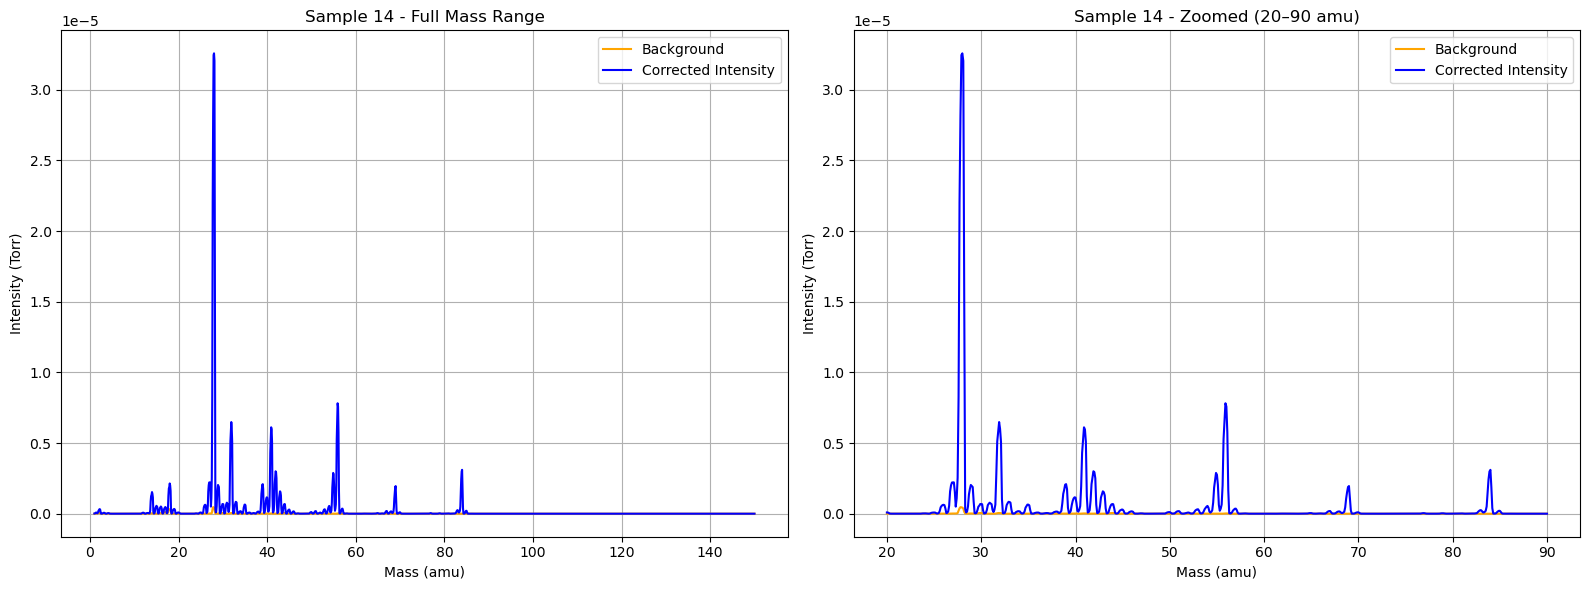

In [5]:
# @title Default title text
import pandas as pd
import matplotlib.pyplot as plt
import requests

# URLs for the unknown compound
data_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%204/R1%20sample%2014.txt"
background_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%204/background.txt"

# Function to parse mass spec data from a URL
def parse_data_from_url(url):
    response = requests.get(url)
    lines = response.text.splitlines()

    # Find where numeric data begins
    data_start_index = 0
    for i, line in enumerate(lines):
        if line.strip().replace('.', '', 1).replace('-', '', 1).replace('E', '', 1).replace('+', '', 1).replace(',', '').isdigit():
            data_start_index = i
            break

    masses = []
    intensities = []
    for line in lines[data_start_index:]:
        parts = line.strip().split(',')
        if len(parts) >= 2:
            try:
                mass = float(parts[0])
                intensity = float(parts[1])
                masses.append(mass)
                intensities.append(intensity)
            except ValueError:
                continue
    return pd.DataFrame({'mass': masses, 'intensity': intensities})

# Load data
data_df = parse_data_from_url(data_url)
background_df = parse_data_from_url(background_url)

# Merge data on mass values
merged_df = pd.merge(data_df, background_df, on='mass', how='inner', suffixes=('_data', '_background'))

# Compute corrected intensity and clip negatives to 0
merged_df['corrected_intensity'] = (merged_df['intensity_data'] - merged_df['intensity_background']).clip(lower=0)

# Filtered version for 20–90 amu
filtered_df = merged_df[(merged_df['mass'] >= 20) & (merged_df['mass'] <= 90)]

# Plotting side-by-side
plt.figure(figsize=(16, 6))

# Plot 1: Full mass range
plt.subplot(1, 2, 1)
plt.plot(merged_df['mass'], merged_df['intensity_background'], color='orange', label='Background')
plt.plot(merged_df['mass'], merged_df['corrected_intensity'], color='blue', label='Corrected Intensity')
plt.xlabel('Mass (amu)')
plt.ylabel('Intensity (Torr)')
plt.title('Sample 14 - Full Mass Range')
plt.legend()
plt.grid(True)

# Plot 2: Zoomed 20–90 amu
plt.subplot(1, 2, 2)
plt.plot(filtered_df['mass'], filtered_df['intensity_background'], color='orange', label='Background')
plt.plot(filtered_df['mass'], filtered_df['corrected_intensity'], color='blue', label='Corrected Intensity')
plt.xlabel('Mass (amu)')
plt.ylabel('Intensity (Torr)')
plt.title('Sample 14 - Zoomed (20–90 amu)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Task 4.2

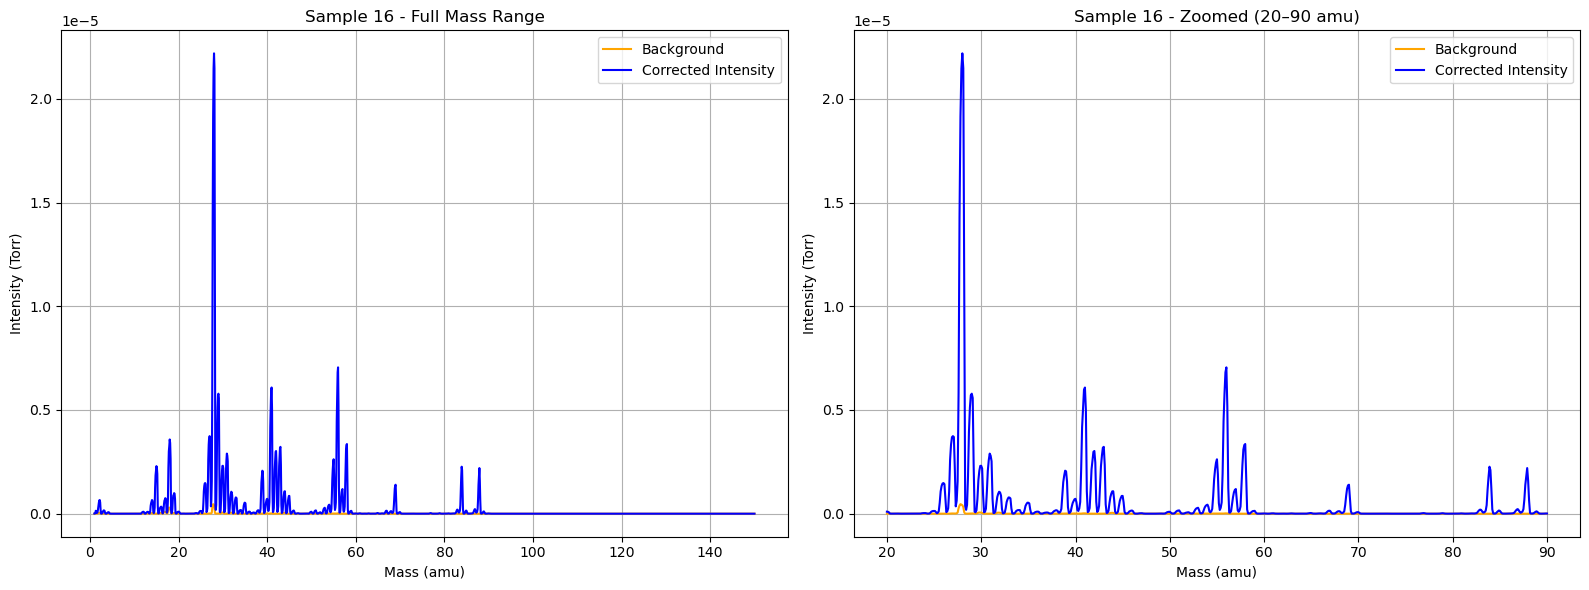

In [6]:
# @title Default title text
import pandas as pd
import matplotlib.pyplot as plt
import requests

# URLs for the unknown compound
data_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%204.2/R1%20sample%2016.txt"
background_url = "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/M23/Task%204.2/background.txt"

# Function to parse mass spec data from a URL
def parse_data_from_url(url):
    response = requests.get(url)
    lines = response.text.splitlines()

    # Find where numeric data begins
    data_start_index = 0
    for i, line in enumerate(lines):
        if line.strip().replace('.', '', 1).replace('-', '', 1).replace('E', '', 1).replace('+', '', 1).replace(',', '').isdigit():
            data_start_index = i
            break

    masses = []
    intensities = []
    for line in lines[data_start_index:]:
        parts = line.strip().split(',')
        if len(parts) >= 2:
            try:
                mass = float(parts[0])
                intensity = float(parts[1])
                masses.append(mass)
                intensities.append(intensity)
            except ValueError:
                continue
    return pd.DataFrame({'mass': masses, 'intensity': intensities})

# Load data
data_df = parse_data_from_url(data_url)
background_df = parse_data_from_url(background_url)

# Merge data on mass values
merged_df = pd.merge(data_df, background_df, on='mass', how='inner', suffixes=('_data', '_background'))

# Compute corrected intensity and clip negatives to 0
merged_df['corrected_intensity'] = (merged_df['intensity_data'] - merged_df['intensity_background']).clip(lower=0)

# Filtered version for 20–90 amu
filtered_df = merged_df[(merged_df['mass'] >= 20) & (merged_df['mass'] <= 90)]

# Plotting side-by-side
plt.figure(figsize=(16, 6))

# Plot 1: Full mass range
plt.subplot(1, 2, 1)
plt.plot(merged_df['mass'], merged_df['intensity_background'], color='orange', label='Background')
plt.plot(merged_df['mass'], merged_df['corrected_intensity'], color='blue', label='Corrected Intensity')
plt.xlabel('Mass (amu)')
plt.ylabel('Intensity (Torr)')
plt.title('Sample 16 - Full Mass Range')
plt.legend()
plt.grid(True)

# Plot 2: Zoomed 20–90 amu
plt.subplot(1, 2, 2)
plt.plot(filtered_df['mass'], filtered_df['intensity_background'], color='orange', label='Background')
plt.plot(filtered_df['mass'], filtered_df['corrected_intensity'], color='blue', label='Corrected Intensity')
plt.xlabel('Mass (amu)')
plt.ylabel('Intensity (Torr)')
plt.title('Sample 16 - Zoomed (20–90 amu)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
